# This notebook trains and predict crop yields using 32 bins histograms 

In [1]:
!pip install Hub

In [2]:
import tensorflow as tf
from hub import Dataset
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
print(tf.__version__)
# check if notebook is using GPU
tf.test.gpu_device_name()

2.4.0


''

### Functions

### Load data from ActiveLoop

In [3]:
crop_type = 'rice'

print("Load data from ActiveLoop ...")

###### MAIZE ########
if crop_type.lower() == 'maize':
  tag1 = "margauxmforsythe/SouthSudan_departments_histograms_weeks_19_30_Maize" # 2010, 2011, 2014, 2015
  tag2 = "margauxmforsythe/Ethiopia_histograms_weeks_19_30_Maize" # 2004, 2013, 2015, 2016

  tag3 = "margauxmforsythe/Senegal_IPAR_histograms_weeks_19_30_Maize"

  ds1 = Dataset(tag1)
  ds2 = Dataset(tag2)
  ds3 = Dataset(tag3)
  
  print("Dataset {} shape:".format(tag1, ds1["histograms"].compute().shape))
  print("Dataset {} shape:".format(ds2["histograms"].compute().shape))

  histograms = np.concatenate((ds1["histograms"].compute(), ds2["histograms"].compute(), ds3["histograms"].compute()), axis=0)
  yields_list = np.concatenate((ds1["yields"].compute(), ds2["yields"].compute(), ds3["yields"].compute()), axis=0)

  print("Datasets combined, histograms set's shape is {}".format(histograms.shape))
  print("Data loaded from {}, {} and {}".format(tag1, tag2, tag3))

###### RICE ########
if crop_type.lower() == 'rice':
  tag1 = "margauxmforsythe/Senegal_histograms_weeks_19_30_Rice_winter_augmented" 
  tag2 = "margauxmforsythe/Senegal_histograms_weeks_19_30_augmented_Rice_CSC"
  # tag1 = "margauxmforsythe/Senegal_histograms_weeks_19_30_rice_winter"
  # tag2 = "margauxmforsythe/Senegal_histograms_weeks_19_30_rice_CSC"

  ds1 = Dataset(tag1)
  ds2 = Dataset(tag2)
  print(ds1["histograms"].compute().shape)
  print(ds2["histograms"].compute().shape)
  histograms = np.concatenate((ds1["histograms"].compute(), ds2["histograms"].compute()), axis=0)
  yields_list = np.concatenate((ds1["yields"].compute(), ds2["yields"].compute()), axis=0)
  print(histograms.shape)
  print("Data loaded from {} and {}".format(tag1, tag2))
  
###### MILLET ########
if crop_type.lower() == 'millet':
  tag = "margauxmforsythe/Senegal_IPAR_histograms_weeks_21_30_Millet"
  # tag = "margauxmforsythe/Senegal_IPAR_histograms_weeks_21_30_Millet_augmented"
  ds = Dataset(tag)
  histograms = ds["histograms"].compute()
  yields_list = ds["yields"].compute()

  print("Data loaded from {}".format(tag))

if crop_type.lower() != 'millet' and crop_type.lower() != 'maize' and crop_type.lower() != 'rice': 
  print("Please choose a crop type between maize and millet")

yields = []
for i in range(0,len(yields_list)):
    yields.append(float(yields_list[i][0]))

print("There are {} yield values for training ".format(len(yields)))

Load data from ActiveLoop ...
(581, 32, 11, 9)
(446, 32, 11, 9)
(1027, 32, 11, 9)
Data loaded from margauxmforsythe/Senegal_histograms_weeks_19_30_Rice_winter_augmented and margauxmforsythe/Senegal_histograms_weeks_19_30_augmented_Rice_CSC
There are 1027 yield values for training 


In [4]:
# Get image width, height and channels from the dataset
img_width = histograms[0].shape[0]
img_height = histograms[0].shape[1]
batch_size = 16
channels = histograms[0].shape[2]
shape = (img_width, img_height, channels)
print("Shape input images: {}".format(shape)) # (bins*time steps*bands)

image_count = histograms.shape[0]
print("Image count: {}".format(image_count))
CNN_LSTM = True

# With CNN_LSTM, we need to re arrange the data to (time steps*1*bins*bands)
if CNN_LSTM:
  histograms_CNN_LSTM = []
  for i in range(image_count):
    histogram_all_timestamps_transposed = np.transpose(histograms[i], (1,0,2))
    timestamps = []
    for j in range(histograms[i].shape[1]): # going through all timestamps
      timestamps.append(np.expand_dims(histogram_all_timestamps_transposed[j], axis=0))
    histograms_CNN_LSTM.append(timestamps)
  histograms = histograms_CNN_LSTM


Shape input images: (32, 11, 9)
Image count: 1027


In [5]:
assert len(histograms) == len(yields)
list_ds = tf.data.Dataset.from_tensor_slices((histograms, yields))
print("Total files: {}".format(image_count))

Total files: 1027


In [6]:
train_size = int(0.8 * image_count)
val_size = int(0.1 * image_count)
test_size = int(0.1 * image_count)

list_ds = list_ds.shuffle(len(list_ds))
test_ds = list_ds.take(test_size)
train_ds = list_ds.skip(test_size)
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

n_training_files = len(train_ds)
print("Total files: {}".format(len(histograms)))
print("Training files: {}".format(len(train_ds)))
print("Validation files: {}".format(len(val_ds)))

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(len(train_ds)).repeat()
train_ds = train_ds.batch(batch_size)

val_ds = val_ds.cache()
val_ds = val_ds.shuffle(val_size)
val_ds = val_ds.batch(val_size)

test_ds = test_ds.cache()
test_ds = test_ds.batch(len(test_ds))

Total files: 1027
Training files: 823
Validation files: 102


### Display first band images in batch to check the data is correct

In [7]:
image_batch_train, label_batch_train = next(iter(train_ds))
image_batch_val, label_batch_val= next(iter(val_ds))
image_batch_test, label_batch_test= next(iter(test_ds))

print(image_batch_train.shape)
if not CNN_LSTM:
  # Check if images are correct
  plt.figure(figsize=(10, 10))
  plt.suptitle("all bands first image")
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch_train[0][:,:,i].numpy())
    label = label_batch_train[0]
    plt.title(label.numpy())
    plt.axis("off")

  plt.show()
else:
  input_shape_cnn_lstm = (image_batch_train.shape[1], image_batch_train.shape[2], 
                          image_batch_train.shape[3], image_batch_train.shape[4])
  print("input_shape_cnn_lstm: {} = (timestamps*1*bins*bands)".format(input_shape_cnn_lstm))
  input_shape_cnn = (image_batch_train.shape[2], image_batch_train.shape[3], image_batch_train.shape[4])
  print("input_shape_cnn: {} = (1*bins*bands)".format(input_shape_cnn))

(16, 11, 1, 32, 9)
input_shape_cnn_lstm: (11, 1, 32, 9) = (timestamps*1*bins*bands)
input_shape_cnn: (1, 32, 9) = (1*bins*bands)


<BarContainer object of 1027 artists>

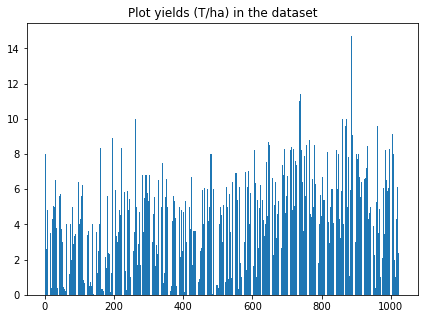

In [8]:
indexes_list = []
for i in range(len(yields)):
  indexes_list.append(i)

plt.figure(figsize=(7,5))
plt.title("Plot yields (T/ha) in the dataset")
plt.bar(indexes_list, yields)

## Build Model: CNN-LSTM

In [9]:
if CNN_LSTM:
  # CNN-LSTM 
  # https://www.mdpi.com/1424-8220/19/20/4363/htm
  from keras.layers.wrappers import TimeDistributed
  from keras.layers import *
  from keras import regularizers
  model=models.Sequential()

  model.add(TimeDistributed(Conv2D(32, (1, 2), activation='relu',
                                   kernel_regularizer=regularizers.l2(0.001),
                                   input_shape=(input_shape_cnn)), input_shape=input_shape_cnn_lstm))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 2))))

  model.add(TimeDistributed(Conv2D(64, (1, 2), activation='relu',
                                   kernel_regularizer=regularizers.l2(0.001))))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 2))))

  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(256, return_sequences=True, activation='relu', dropout=0.25));

  model.add(TimeDistributed(Dense(64)))
  model.add(TimeDistributed(Flatten()))
  model.add(TimeDistributed(Dropout(0.5)))
  model.add(TimeDistributed(Dense(1)))
  model.add(GlobalAveragePooling1D(name="global_avg_flow"))

  model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 11, 1, 31, 32)     608       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 11, 1, 31, 32)     128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 11, 1, 15, 32)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 11, 1, 14, 64)     4160      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 11, 1, 14, 64)     256       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 11, 1, 7, 64)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 11, 448)           0

In [10]:
initial_learning_rate = 0.00001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError(name='RMSE'), tf.keras.losses.MeanSquaredError(name='MSE')])

### Create Callbacks for model fit

In [11]:
checkpoint_file = 'checkpoint_{}_b{}_CNN-LSTM_IPAR_augmented_data.h5'.format(crop_type, batch_size)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_file,
    format='h5',
    verbose=1,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1,
    mode='min', min_lr=1e-10)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=20, verbose=1)

## Training

In [12]:
print("Train ... ")

model.trainable = True
history = model.fit(train_ds,
                    epochs=1000,
                    steps_per_epoch=n_training_files//batch_size,
                    validation_data=val_ds,
                    verbose=1,
                    callbacks=[model_checkpoint_callback, early_stop])


Train ... 
Epoch 1/1000
51/51 [==============================] - 7s 101ms/step - loss: 20.6239 - accuracy: 0.0078 - RMSE: 4.5296 - MSE: 20.5655 - val_loss: 29.3390 - val_accuracy: 0.0000e+00 - val_RMSE: 5.4112 - val_MSE: 29.2806

Epoch 00001: val_loss improved from inf to 29.33895, saving model to checkpoint_rice_b16_CNN-LSTM_IPAR_augmented_data.h5
Epoch 2/1000
51/51 [==============================] - 4s 87ms/step - loss: 9.8645 - accuracy: 0.0113 - RMSE: 3.1263 - MSE: 9.8061 - val_loss: 28.3297 - val_accuracy: 0.0000e+00 - val_RMSE: 5.3171 - val_MSE: 28.2714

Epoch 00002: val_loss improved from 29.33895 to 28.32975, saving model to checkpoint_rice_b16_CNN-LSTM_IPAR_augmented_data.h5
Epoch 3/1000
51/51 [==============================] - 4s 88ms/step - loss: 6.6794 - accuracy: 0.0130 - RMSE: 2.5718 - MSE: 6.6210 - val_loss: 26.9971 - val_accuracy: 0.0000e+00 - val_RMSE: 5.1902 - val_MSE: 26.9387

Epoch 00003: val_loss improved from 28.32975 to 26.99706, saving model to checkpoint_rice_b

### Plots 

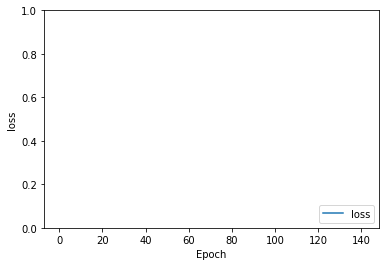

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

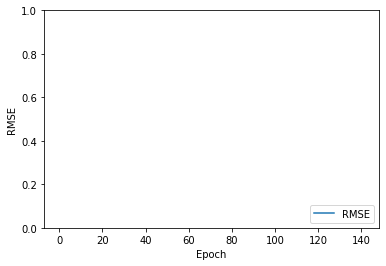

In [14]:
plt.plot(history.history['RMSE'], label='RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

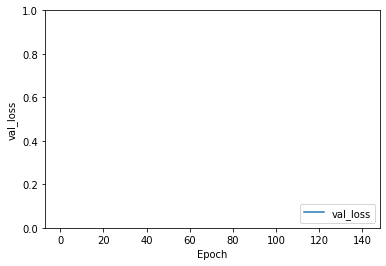

In [15]:
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('val_loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

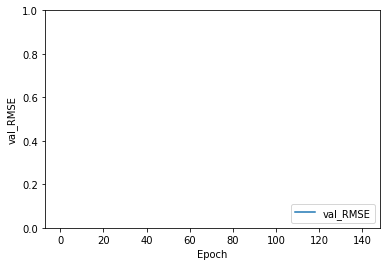

In [16]:
plt.plot(history.history['val_RMSE'], label = 'val_RMSE')
plt.xlabel('Epoch')
plt.ylabel('val_RMSE')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.show()

### Evaluation 

In [17]:
print("\nEvaluating val ds... ")
test_loss, test_acc, test_rmse, test_mse = model.evaluate(val_ds, verbose=1)

print("\nEvaluating test ds (0.1 of all files)... ")
test_loss, test_acc, test_rmse, test_mse = model.evaluate(test_ds, verbose=1)


Evaluating val ds... 
1/1 [==============================] - 0s 92ms/step - loss: 3.1926 - accuracy: 0.0098 - RMSE: 1.7704 - MSE: 3.1343

Evaluating test ds (0.1 of all files)... 
1/1 [==============================] - 0s 83ms/step - loss: 3.0114 - accuracy: 0.0196 - RMSE: 1.7185 - MSE: 2.9531


Evaluate with all 2014 IPAR data

In [26]:
if crop_type.lower() == 'maize':
  tag_test_IPAR = "margauxmforsythe/Senegal_IPAR_histograms_weeks_19_30_Maize"
if crop_type.lower() == 'millet':
  tag_test_IPAR = "margauxmforsythe/Senegal_IPAR_histograms_weeks_21_30_Millet"
if crop_type.lower() == "rice":
  # tag_test_IPAR = "margauxmforsythe/Senegal_histograms_weeks_19_30_rice_winter"
  tag_test_IPAR = "margauxmforsythe/Senegal_histograms_weeks_19_30_rice_CSC"


ds_test_IPAR_all = Dataset(tag_test_IPAR)
test_hists = ds_test_IPAR_all["histograms"].compute()
yields_list_test = ds_test_IPAR_all["yields"].compute()
yields_test_IPAR_all = []
for i in range(0,len(yields_list_test)):
    yields_test_IPAR_all.append(float(yields_list_test[i][0]))
  
# TEST set
histograms_CNN_LSTM_test = []
for i in range(len(test_hists)):
  histogram_all_timestamps_transposed = np.transpose(test_hists[i], (1,0,2))
  timestamps = []
  for j in range(test_hists[i].shape[1]): # going through all timestamps
    timestamps.append(np.expand_dims(histogram_all_timestamps_transposed[j], axis=0))
  histograms_CNN_LSTM_test.append(timestamps)
histograms_test_IPAR_all = histograms_CNN_LSTM_test
print("There are now {} (* {} time steps files) splitted per timestamps of shape {} in the dataset".format(shape[1], len(histograms), histograms_CNN_LSTM[0][0].shape))

test_ds = tf.data.Dataset.from_tensor_slices((histograms_test_IPAR_all, yields_test_IPAR_all))
test_ds = test_ds.cache()
test_ds = test_ds.batch(len(test_ds))
image_batch_test, label_batch_test= next(iter(test_ds))


There are now 11 (* 1027 time steps files) splitted per timestamps of shape (1, 32, 9) in the dataset


In [27]:
model.load_weights(checkpoint_file)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError(name='RMSE'), tf.keras.losses.MeanSquaredError(name='MSE')])


In [28]:
print("\nEvaluating test ds... ")
test_loss, test_acc, test_rmse, test_mse = model.evaluate(test_ds, verbose=1)


Evaluating test ds... 
1/1 [==============================] - 1s 665ms/step - loss: 3.8811 - accuracy: 0.0149 - RMSE: 1.9552 - MSE: 3.8228


### Prediction

In [21]:
if not CNN_LSTM:
  plt.imshow(image_batch_val[0][:,:,0])
  label = label_batch_val[0].numpy()
  plt.title(label)
  plt.axis("off")
else:
  print("real yield: {}".format(label_batch_val[0].numpy()))
predictions = model.predict(image_batch_val)
print("predictions shape:", predictions.shape)
print("prediction:", predictions[0][0])

real yield: 4.3179192543029785
predictions shape: (102, 1)
prediction: 6.0879836


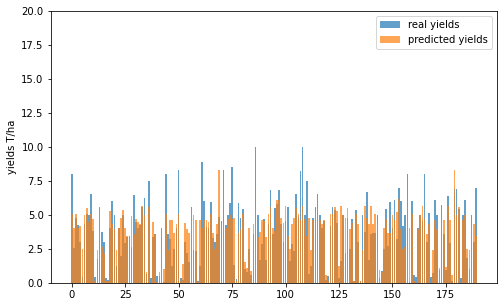

In [22]:
indexes_list = []
for i in range(len(image_batch_test)):
  indexes_list.append(i)

predictions = model.predict(test_ds)
predictions_array = []
for i in range(len(predictions)):
  predictions_array.append(predictions[i][0])
predictions_array

assert len(predictions_array) == len(label_batch_test.numpy())

plt.figure(figsize=(8,5))
plt.ylabel('yields T/ha')
bar1 = plt.bar(indexes_list,label_batch_test.numpy(),label='real yields', alpha=0.7)
bar2 = plt.bar(indexes_list,predictions_array,label='predicted yields', alpha=0.7)
plt.legend()
plt.ylim([0, 20])
plt.show()

<BarContainer object of 190 artists>

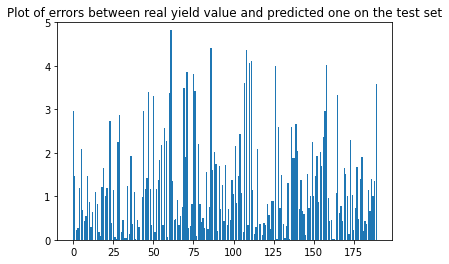

In [23]:
error = abs(predictions_array - label_batch_test.numpy())
plt.title("Plot of errors between real yield value and predicted one on the test set")
plt.ylim([0, 5])
plt.bar(indexes_list,error)

<BarContainer object of 190 artists>

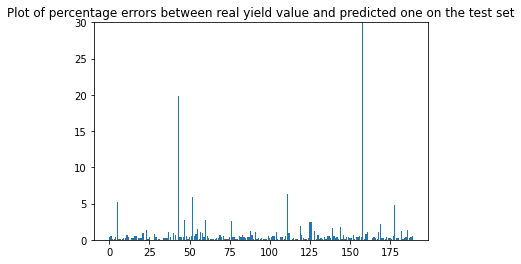

In [24]:
indexes_list = []
for i in range(len(image_batch_test)):
  indexes_list.append(i)

error = abs(predictions_array - label_batch_test.numpy())/label_batch_test.numpy()
plt.title("Plot of percentage errors between real yield value and predicted one on the test set")
plt.ylim([0, 30])
plt.bar(indexes_list,error)

In [25]:
for i in range(len(predictions_array)):
  print("{}) Predicted yield {} T/ha // Real yield {} T/ha".format(i, predictions_array[i], label_batch_test.numpy()[i]))

0) Predicted yield 5.031442642211914 T/ha // Real yield 8.0 T/ha
1) Predicted yield 4.061507701873779 T/ha // Real yield 2.592592477798462 T/ha
2) Predicted yield 5.028602123260498 T/ha // Real yield 4.800000190734863 T/ha
3) Predicted yield 4.003281116485596 T/ha // Real yield 4.285714149475098 T/ha
4) Predicted yield 4.198428153991699 T/ha // Real yield 3.0 T/ha
5) Predicted yield 2.4771485328674316 T/ha // Real yield 0.4000000059604645 T/ha
6) Predicted yield 5.01301908493042 T/ha // Real yield 4.320000171661377 T/ha
7) Predicted yield 5.472768783569336 T/ha // Real yield 5.047826290130615 T/ha
8) Predicted yield 4.456003665924072 T/ha // Real yield 4.994999885559082 T/ha
9) Predicted yield 5.031442642211914 T/ha // Real yield 6.5 T/ha
10) Predicted yield 4.658480644226074 T/ha // Real yield 3.797468423843384 T/ha
11) Predicted yield 0.1089405044913292 T/ha // Real yield 0.4000000059604645 T/ha
12) Predicted yield 2.4001259803771973 T/ha // Real yield 1.75 T/ha
13) Predicted yield 5